### ~~Laplace~~ Gaussian Mechanism for Differential Privacy

In this notebook we extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [1]:
# introduced in wk3
# functions used regularly in examples

import numpy as np


def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=-0.5, high=0.5, size=size)
    draws = shift - scale * np.sign(p) * np.log(1 - 2 * abs(p))
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def gaussian(shift=0., scale=1., size=None):
    """Sample from the Gaussian distribution."""
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws


def clamp(x, bounds):
    """Replace any x_i less than lower with lower,
           and any x_i greater than upper with upper."""
    return np.clip(x, *bounds)


def bounded_mean(x, bounds):
    x_clamped = clamp(x, bounds)
    return np.mean(x_clamped)


def release_dp_mean(x, bounds, epsilon, delta=1e-6, mechanism="laplace"):
    """Release a DP mean.
    Assumes that the dataset size n is public information.
    """
    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower, upper = bounds
    # Sensitivity in terms of an absolute distance metric
    # Both the laplace and gaussian mechanisms can noise queries
    #    with sensitivities expressed in absolute distances
    sensitivity = (upper - lower) / n

    if mechanism == "laplace":
        scale = sensitivity / epsilon
        dp_mean = sensitive_mean + laplace(scale=scale)
    elif mechanism == "gaussian":
        scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta))
        dp_mean = sensitive_mean + gaussian(scale=scale)
    else:
        raise ValueError(f"unrecognized mechanism: {mechanism}")

    return dp_mean


def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]


def release_dp_histogram(x, epsilon, categories):
    """Release an `epsilon`-DP estimate of the counts of each of the `categories`"""
    sensitivity = 2
    scale = sensitivity / epsilon

    # create a {category: count} hashmap
    counts = dict(zip(*np.unique(x, return_counts=True)))
    # look up the count of each category, or zero if not exists
    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
    return dp_histogram

In [4]:
import numpy as np

# established in previous lectures
#from mock_dp_library import *


def gaussian(shift=0., scale=1., size=None):
    """Sample from the Gaussian distribution."""
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws


def release_dp_mean(x, bounds, epsilon, delta=1e-6, mechanism="laplace"):
    """Release a DP mean.
    Assumes that the dataset size n is public information.
    """
    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower, upper = bounds
    # Sensitivity in terms of an absolute distance metric
    # Both the laplace and gaussian mechanisms can noise queries
    #    with sensitivities expressed in absolute distances
    sensitivity = (upper - lower) / n

    if mechanism == "laplace":
        scale = sensitivity / epsilon
        dp_mean = sensitive_mean + laplace(scale=scale)
    elif mechanism == "gaussian":
        scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta))
        dp_mean = sensitive_mean + gaussian(scale=scale)
    else:
        raise ValueError(f"unrecognized mechanism: {mechanism}")

    return dp_mean

    # the compact way
    # return laplace(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))
    # return gaussian(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [5]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1., 16.)  # easily guessable without looking at the data

educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, bounds=educ_bounds, epsilon=1.))

10.608672101325384


We're going to simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [6]:
n_sims = 1000

n_seq = np.logspace(start=np.log10(200), stop=np.log10(1500), num=15).astype(int)
print("N sequence      ", n_seq)

ep_seq = np.around(np.logspace(start=np.log10(1), stop=np.log10(0.1), num=5), decimals=2)
print("epsilon sequence", ep_seq)

my_delta = 1e-6

agg_history = []

aggcount = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(ep_seq):
        sq_error_laplace = sq_error_gaussian = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
            dp_mean_laplace = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim, mechanism="laplace")
            dp_mean_gaussian = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim, delta=my_delta, mechanism="gaussian")
            sq_error_laplace += (dp_mean_laplace - sensitive_mean) ** 2
            sq_error_gaussian += (dp_mean_gaussian - sensitive_mean) ** 2

        agg_history.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error_laplace/n_sims),   # RMSE Laplace
            np.sqrt(sq_error_gaussian/n_sims)   # RMSE Gaussian
        ])


agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "laplace error", "gaussian error"])


N sequence       [ 200  230  266  307  355  410  474  547  632  730  843  974 1124 1298
 1500]
epsilon sequence [1.   0.56 0.32 0.18 0.1 ]


Graphing our results is often a case of finding an approximate template and then tweaking it to convey the exact details of interest to your reader.  This template for showing the utility of DP releases will likely be commonly useful across your homeworks and project.

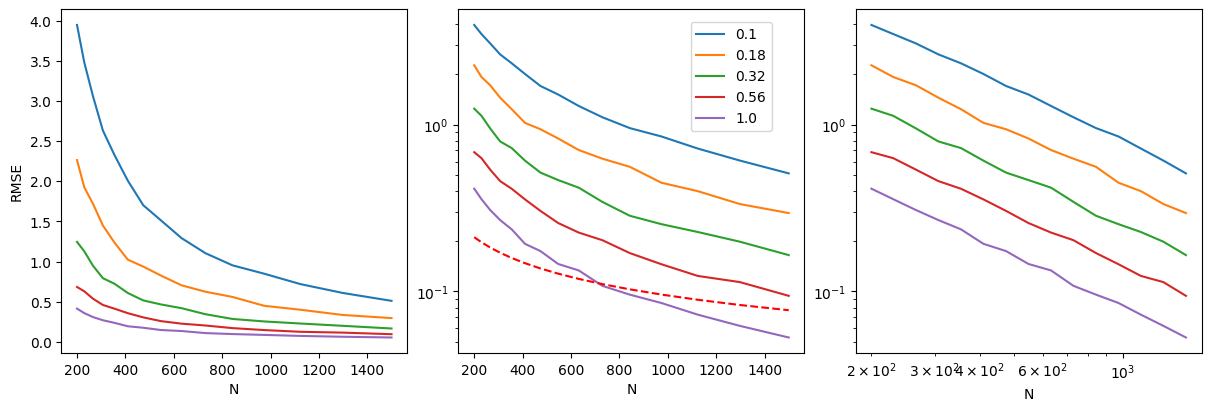

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12,4), layout='constrained')

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="gaussian error", label=epsilon_sim, ax=ax, legend=None)

## Overlay the standard error of the mean
se = np.std(educ) / np.sqrt(n_seq)
axs[1].plot(n_seq, se, linestyle='dashed', color="red")

_ = fig.legend(*axs[0].get_legend_handles_labels(), loc=(0.57, 0.68))


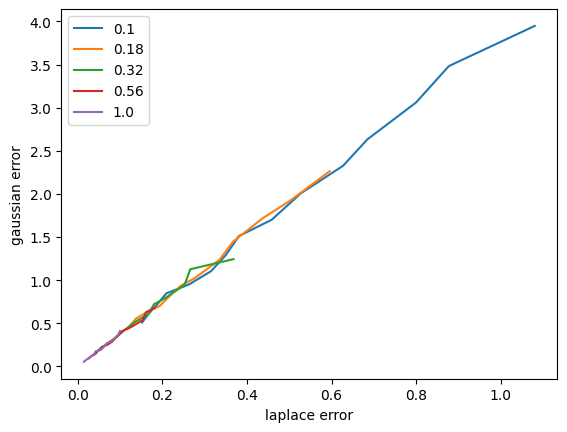

In [8]:
for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    subhistory.plot(x="laplace error", y="gaussian error", label=epsilon_sim, ax=plt.gca())
_ = plt.ylabel("gaussian error")